# Compression

In [2]:
## Imports

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import chain
from itertools import groupby
import scipy.misc
import scipy.signal
from scipy import ndimage
import time
import os
import cPickle
from matplotlib.colors import LogNorm
import sklearn.cluster

## Convert `tots.ipynb` notebook to an ordinary python script, so that it can be imported here

!jupyter nbconvert --to script tots.ipynb
import event_converter
import cluster_sizes
import tots
reload(event_converter)
reload(cluster_sizes)
reload(tots)
from event_converter import *
from cluster_sizes import *
from tots import *

print 'Done.'

[NbConvertApp] Converting notebook tots.ipynb to script
[NbConvertApp] Writing 14414 bytes to tots.py
[NbConvertApp] Converting notebook event_converter.ipynb to script
[NbConvertApp] Writing 4196 bytes to event_converter.py


<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook cluster_sizes.ipynb to script
[NbConvertApp] Writing 14752 bytes to cluster_sizes.py
[NbConvertApp] Converting notebook event_converter.ipynb to script
[NbConvertApp] Writing 4196 bytes to event_converter.py


<IPython.core.display.Javascript object>

Done.


<IPython.core.display.Javascript object>

Done.


In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
// this cell fixes the scroll boxes that are otherwise quite irritating

<IPython.core.display.Javascript object>

591
662
460
592
694
692
2288


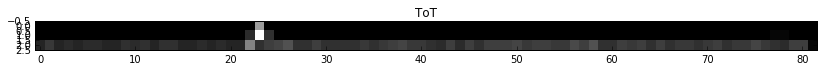

In [4]:
def zrle_cluster_bit_length(cluster_tot):
    bit_sum = 0
    for i, (count, val) in enumerate([(len(list(group)), value) for value, group in groupby(np.ravel(cluster_tot))]):
            bits = 2*7 if val == 0 else count*7
            bit_sum += bits
    return bit_sum + 19 + bit_size_ex_golumb(cluster_tot.shape[0] - 2)

def bit_size_ex_golumb(val):
    x = -val*2 + 1 if val <= 0 else val*2
    bits = int(floor(log(x)/log(2)))
    return bits + bits + 1

def line_cluster_bit_length(cluster_tot):
    left_max = np.argmax(cluster_tot, axis=0)[0]
    right_max = np.argmax(cluster_tot, axis=0)[-1]
    y0 = left_max
    y1 = right_max
    num = cluster_tot.shape[1]
    x, y = np.linspace(0, cluster_tot.shape[1]-1, num), np.linspace(y0, y1, num)
    mean = cluster_tot[np.round([y,x]).astype(int).tolist()].mean()
    prediction = np.round(make_line_prediction(cluster_tot.shape, y0, y1) * mean)
    
    # Left and right edge and mean
    bit_sum = 7*3
    for i, (count, val) in enumerate([(len(list(group)), value) for value, group in groupby(np.ravel(cluster_tot - prediction))]):
            val_ex_golumnb = bit_size_ex_golumb(val)
            bits = val_ex_golumnb + bit_size_ex_golumb(count) if val == 0 else count*val_ex_golumnb
            #print count, val, '->', bits
            bit_sum += bits
    return bit_sum + 19 + bit_size_ex_golumb(cluster_tot.shape[0] - 2)

def line_lzw_cluster_bit_length(cluster_tot):
    left_max = np.argmax(cluster_tot, axis=0)[0]
    right_max = np.argmax(cluster_tot, axis=0)[-1]
    y0 = left_max
    y1 = right_max
    num = cluster_tot.shape[1]
    x, y = np.linspace(0, cluster_tot.shape[1]-1, num), np.linspace(y0, y1, num)
    mean = cluster_tot[np.round([y,x]).astype(int).tolist()].mean()
    prediction = np.round(make_line_prediction(cluster_tot.shape, y0, y1) * mean)
    
    bit_range = int(np.max(cluster_tot - prediction) - np.min(cluster_tot - prediction) + 1)
    seq = (cluster_tot - prediction - np.min(cluster_tot - prediction)).ravel().astype(int)
    seq_compressed = lzw(seq, bit_range)
    bits_per_code = int(ceil(log(0.1+np.max(seq_compressed + [1]))/log(2)))
    return len(seq_compressed)*bits_per_code + 8 + 8 + 8 + 19 + bit_size_ex_golumb(cluster_tot.shape[0] - 2)

def lzw(seq, dictionary_size):
    dictionary = dict(((i,), i) for i in xrange(0, dictionary_size))
    size = len(dictionary)

    buf = []
    out = []
    
    for i in seq:
        sym = [i]
        if tuple(buf+sym) in dictionary:
            buf = buf+sym
        else:
            out.append(dictionary[tuple(buf)])
            dictionary[tuple(buf+sym)] = size
            size += 1
            buf = sym
    if buf:
        out.append(dictionary[tuple(buf)])
    return out

def lzw_decompress(compressed_seq, dictionary_size):
    dictionary = dict((i, [i]) for i in xrange(0, dictionary_size))
    size = len(dictionary)
    
    out = []
    buf = dictionary[compressed_seq.pop(0)]
    out += buf
    for i in compressed_seq:
        if i in dictionary:
            entry = dictionary[i]
        elif i == size:
            entry = buf + [buf[0]]
        else:
            raise ValueError('Bad compressed i: %s' % i)
        out += entry

        dictionary[size] = buf + [entry[0]]
        size += 1
 
        buf = entry
    return out

def lzw_cluster_bit_length(cluster_tot):
    bit_range = int(np.max(cluster_tot) + 1)
    seq = cluster_tot.ravel().astype(int)
    seq_compressed = lzw(seq, bit_range)
    bits_per_code = int(ceil(log(np.max(seq_compressed))/log(2)))
    return len(seq_compressed)*bits_per_code + 8 + 8 + 19 + bit_size_ex_golumb(cluster_tot.shape[0] - 2)

def lzw_cds_cluster_bit_length(cluster_tot):
    seq = cluster_tot.ravel().astype(int)
    seq_compressed = lzw(seq, 128)
    bits_per_code = int(ceil(log(np.max(seq_compressed))/log(2)))
    return len(seq_compressed)*bits_per_code + 8 + 19 + bit_size_ex_golumb(cluster_tot.shape[0] - 2)

def row_cluster_cluster_bit_length(cluster_tot):
    bit_sum = 0
    binary_cluster = np.zeros(cluster_tot.shape)
    binary_cluster[np.where(cluster_tot > 0)] = 1
    for i, (count, val) in enumerate([(len(list(group)), value) for value, group in groupby(np.ravel(binary_cluster))]):
            bits = 0 if val == 0 else count*7 + 19
            bit_sum += bits
    return bit_sum

def base_cluster_bit_length(cluster_tot):
    num_hits = len(np.where(cluster_tot > 0)[0])
    return num_hits * (19 + 7)

def cluster_cluster_bit_length(cluster_tot):
    length = cluster_tot.shape[1]
    height = cluster_tot.shape[0]
    return 19 + 7*length*height + bit_size_ex_golumb(cluster_tot.shape[0] - 2)

cluster_tots = get_cluster_tots(25, 10)
cluster_tot = cluster_tots[1][1]
show_gray(cluster_tot, 'ToT', vmin=0)

print lzw_cluster_bit_length(cluster_tot)
print lzw_cds_cluster_bit_length(cluster_tot)
print line_cluster_bit_length(cluster_tot)
print line_lzw_cluster_bit_length(cluster_tot)
print zrle_cluster_bit_length(cluster_tot)
print row_cluster_cluster_bit_length(cluster_tot)
print base_cluster_bit_length(cluster_tot)

In [5]:
def bit_sizes_for_alg_path_and_filename(eta, phi, alg):
    return ('data/compression_bit_sizes/' + str(eta) + '/' + str(phi) + '/', alg + '.npy')

def load_bit_sizes_for_alg(eta, phi, alg):
    path, filename = bit_sizes_for_alg_path_and_filename(eta, phi, alg)
    if not os.path.exists(path):
        os.makedirs(path)
        
    bits = [[] for x in range(1000)]
    
    cluster_tots = get_cluster_tots(eta, phi)
    for eventID, clusters in cluster_tots.iteritems():
        for (i, cluster_tot) in enumerate(clusters):
            length = min(len(np.where(cluster_tot > 0)[0]), 999)
            cluster_bit_length = globals()[alg + '_cluster_bit_length'](cluster_tot)
            bits[length].append(cluster_bit_length)
    
    np.save(path + filename, bits)
    return bits
        
def get_bit_sizes_for_alg(eta, phi, alg, force_reload=False):
    path, filename = bit_sizes_for_alg_path_and_filename(eta, phi, alg)
    if force_reload or not os.path.exists(path + filename):
        return load_bit_sizes_for_alg(eta, phi, alg)
    else:
        return np.load(path + filename)

In [7]:
algs = ['base', 'cluster', 'row_cluster', 'zrle', 'line', 'lzw']

for eta_i in range(0, 31):
    print 'eta:', eta_i, 'phi:',
    for phi_i in range(0,16):
        print phi_i,
        for alg in algs:
            get_bit_sizes_for_alg(eta_i, phi_i, alg, force_reload=False)
    print

eta: 0 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 1 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 2 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 3 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 4 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 5 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 6 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 7 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 8 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 9 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 10 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 11 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12

eta: -30 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -29 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -28 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -27 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -26 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -25 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -24 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -23 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -22 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -21 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -20 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -11 phi

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in divide


 0.370174940037


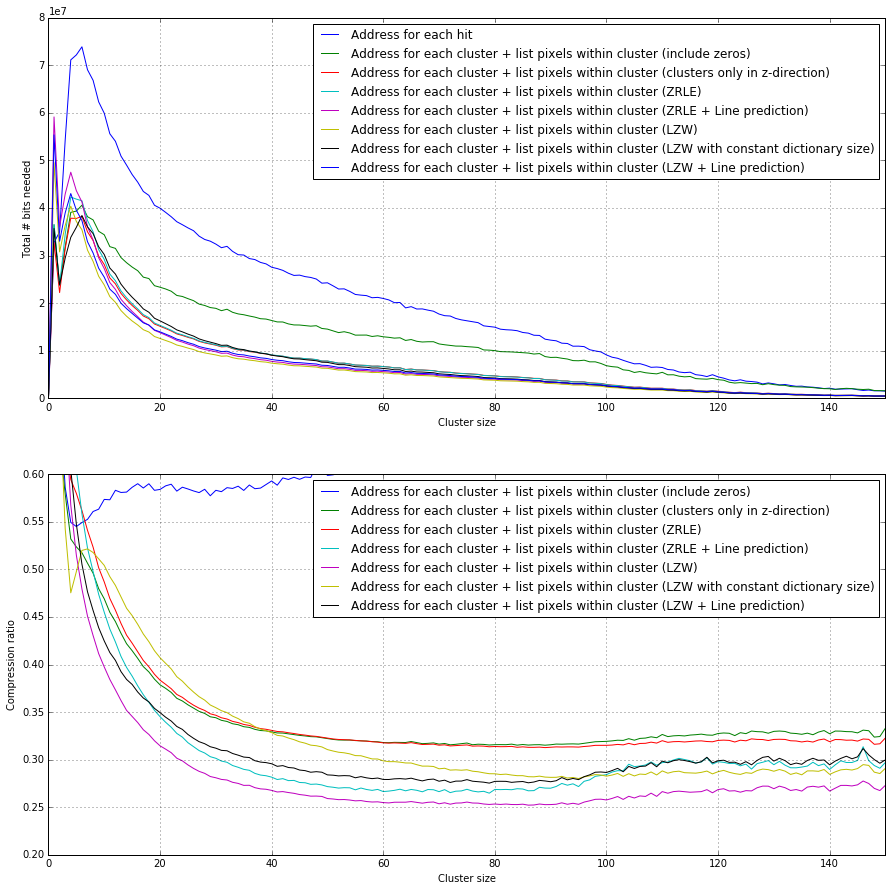

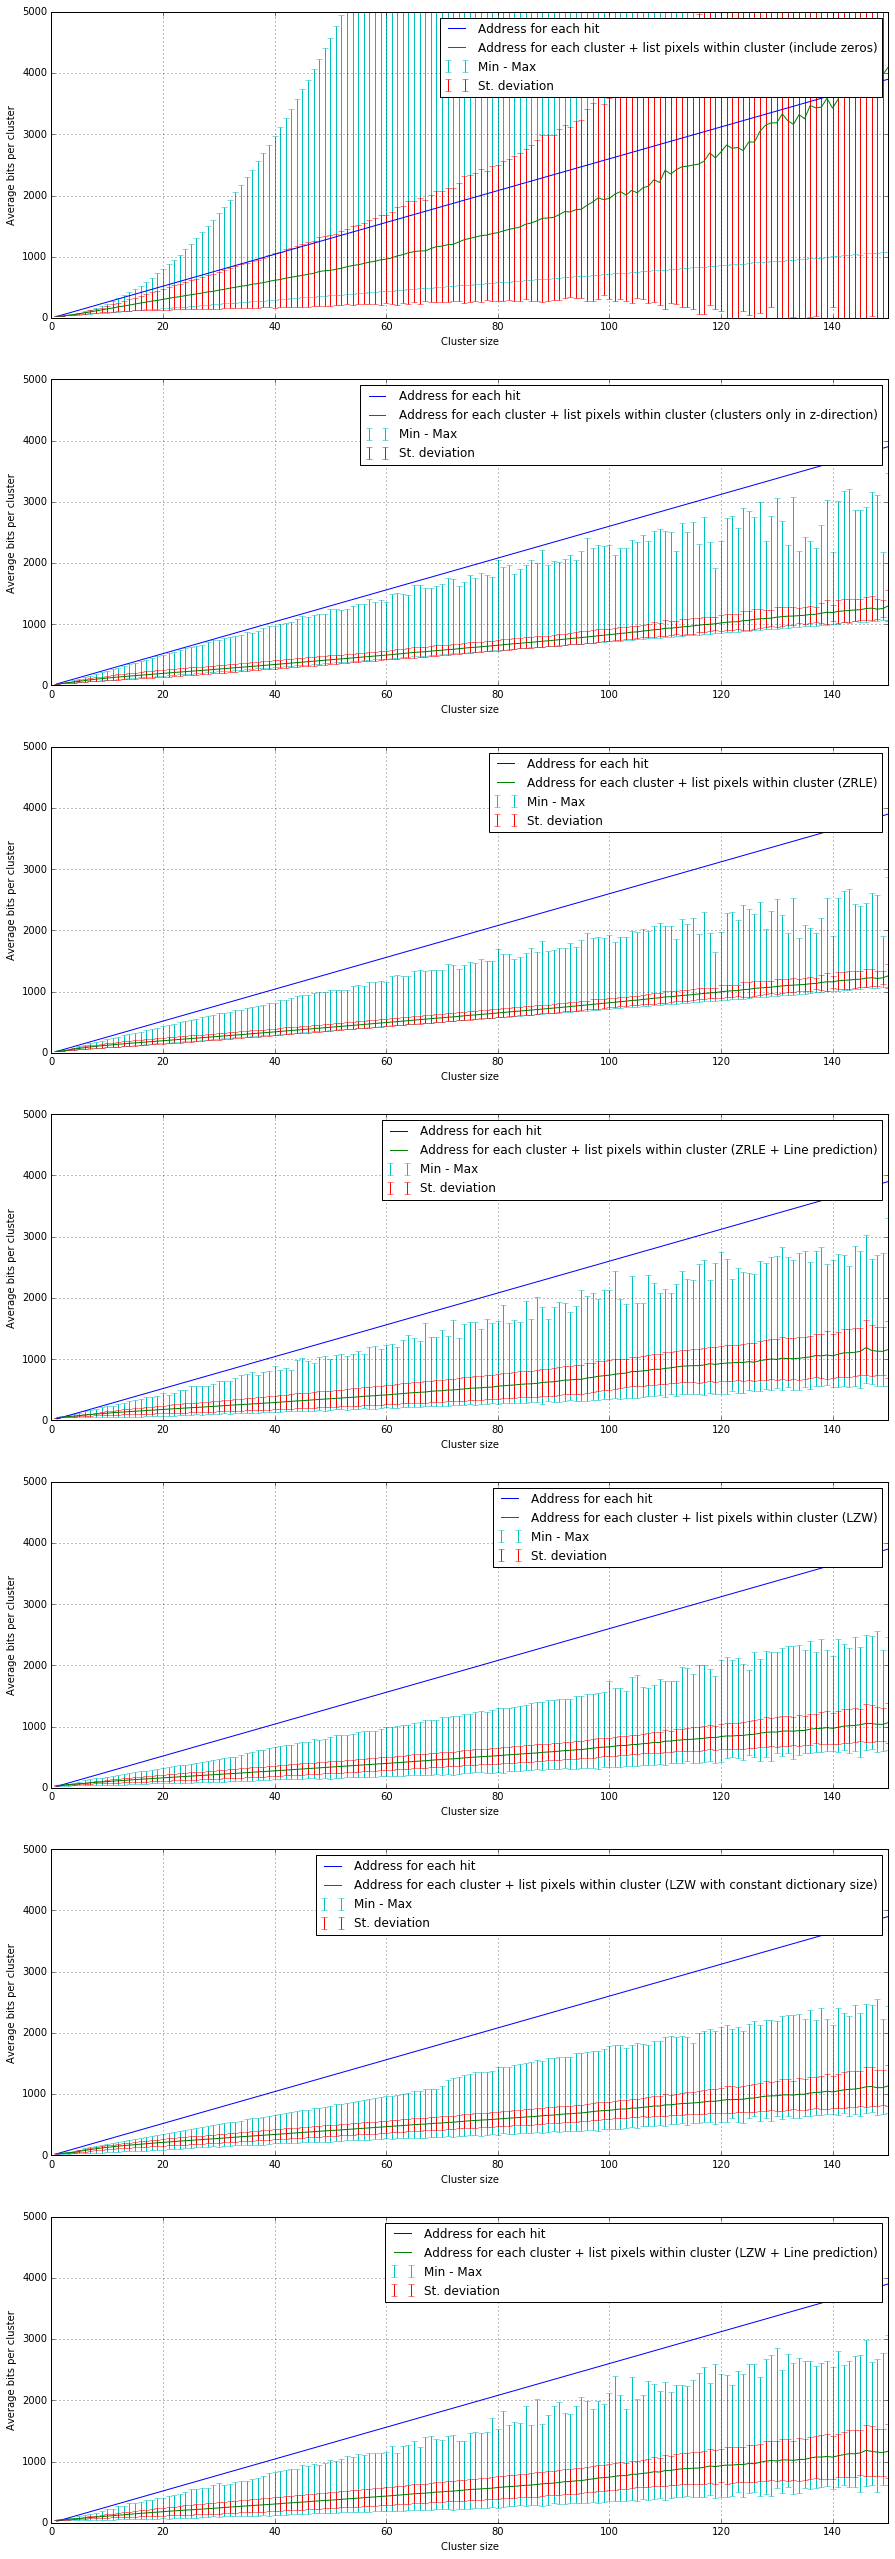

In [9]:
algs = ['base', 'cluster', 'row_cluster', 'zrle', 'line', 'lzw', 'lzw_cds', 'line_lzw']

compression_bits = {}
for alg in algs:
    compression_bits[alg] = [[] for x in range(1000)]

for eta_i in range(-30, 31):
    print 'eta:', eta_i, 'phi:',
    for phi_i in range(0,16):
        print phi_i,
        for alg in algs:
            bits_per_size = get_bit_sizes_for_alg(eta_i, phi_i, alg)
            for size, bits in enumerate(bits_per_size):
                if len(bits) > 0:
                    compression_bits[alg][size] += bits
    print

plt.figure(figsize=(15,15))
plt.subplot(211)

alg_labels = {
    'base': 'Address for each hit', 
    'cluster': 'Address for each cluster + list pixels within cluster (include zeros)',
    'row_cluster': 'Address for each cluster + list pixels within cluster (clusters only in z-direction)',
    'zrle': 'Address for each cluster + list pixels within cluster (ZRLE)',
    'line': 'Address for each cluster + list pixels within cluster (ZRLE + Line prediction)',
    'line_lzw': 'Address for each cluster + list pixels within cluster (LZW + Line prediction)',
    'lzw': 'Address for each cluster + list pixels within cluster (LZW)',
    'lzw_cds': 'Address for each cluster + list pixels within cluster (LZW with constant dictionary size)',
    'optimal': 'The best option'
}

base_sums = np.zeros((1000))+0.00001
for i, bits in enumerate(compression_bits['base']):
    base_sums[i] = np.sum(bits)
base_total_sum = np.sum(base_sums)

for alg in algs:
    sums = np.zeros((1000))
    for i, bits in enumerate(compression_bits[alg]):
        sums[i] = np.sum(bits)
    plt.plot( sums, label=alg_labels[alg])
    print 'Overall compression ratio(' + alg +  '):', np.sum(sums) / base_total_sum
    
plt.legend()
plt.xlabel('Cluster size')
plt.grid(True)
plt.ylabel('Total # bits needed')
plt.xlim([0, 150])

plt.subplot(212)
for alg in algs:
    if alg == 'base':
        continue
    sums = np.zeros((1000))
    for i, bits in enumerate(compression_bits[alg]):
        sums[i] = np.sum(bits)
    plt.plot(1.0*sums/base_sums, label=alg_labels[alg])
plt.legend()
plt.xlim([0, 150])
plt.ylim([0.2, 0.6])
plt.xlabel('Cluster size')
plt.grid(True)
plt.ylabel('Compression ratio')
plt.savefig('compression_ratios_comp2.png')

plt.figure(figsize=(15,45))

for i, alg in enumerate(algs):
    if alg == 'base':
        continue
    plt.subplot(7,1,i)
    err = np.zeros((1000))
    avg = np.zeros((1000))
    max_bits = np.zeros((1000))
    min_bits = np.zeros((1000))
    sums = np.zeros((1000))
    counts = np.zeros((1000)) + 0.0001
    for i, bits in enumerate(compression_bits[alg]):
        err[i] = np.std(bits)
        max_bits[i] = np.max(bits + [0])
        min_bits[i] = np.min(bits + [99999999])
        sums[i] = np.sum(bits)
        counts[i] = len(bits)
        avg[i] = np.mean(bits)
    err_up = max_bits - avg
    err_down = avg - min_bits
    plt.errorbar(range(1000), avg, yerr=[err_down, err_up], label='Min - Max', color='none', ecolor='c')
    plt.errorbar(range(1000), avg, yerr=err, label='St. deviation', color='none', ecolor='r')
    plt.plot(1.0*base_sums/counts, label=alg_labels['base'])
    plt.plot(avg, label=alg_labels[alg])
    plt.legend()
    plt.xlim([0, 150])
    plt.ylim([0, 5000])
    #plt.yscale('log')
    plt.xlabel('Cluster size')
    plt.grid(True)
    plt.ylabel('Average bits per cluster')
plt.savefig('compression_ratios_comp3.png')

# TODO: cluster shape information

Overall compression ratio(base): 1.0
Overall compression ratio(cluster): 0.655855068743
Overall compression ratio(row_cluster): 0.385092610417
Overall compression ratio(zrle): 0.394783611703
Overall compression ratio(line): 0.376503427964
Overall compression ratio(lzw): 0.338829341283
Overall compression ratio(lzw_cds): 0.38393511182
Overall compression ratio(line_lzw):

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide


 0.370174940037
Overall compression ratio(optimal): 0.316385110925


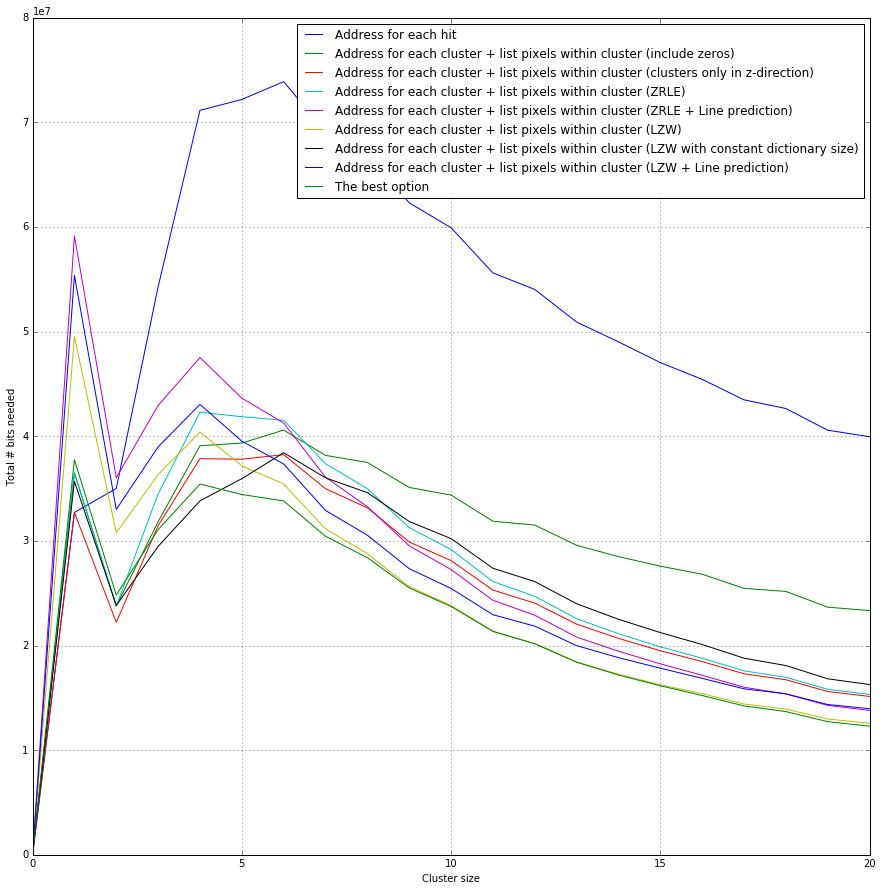

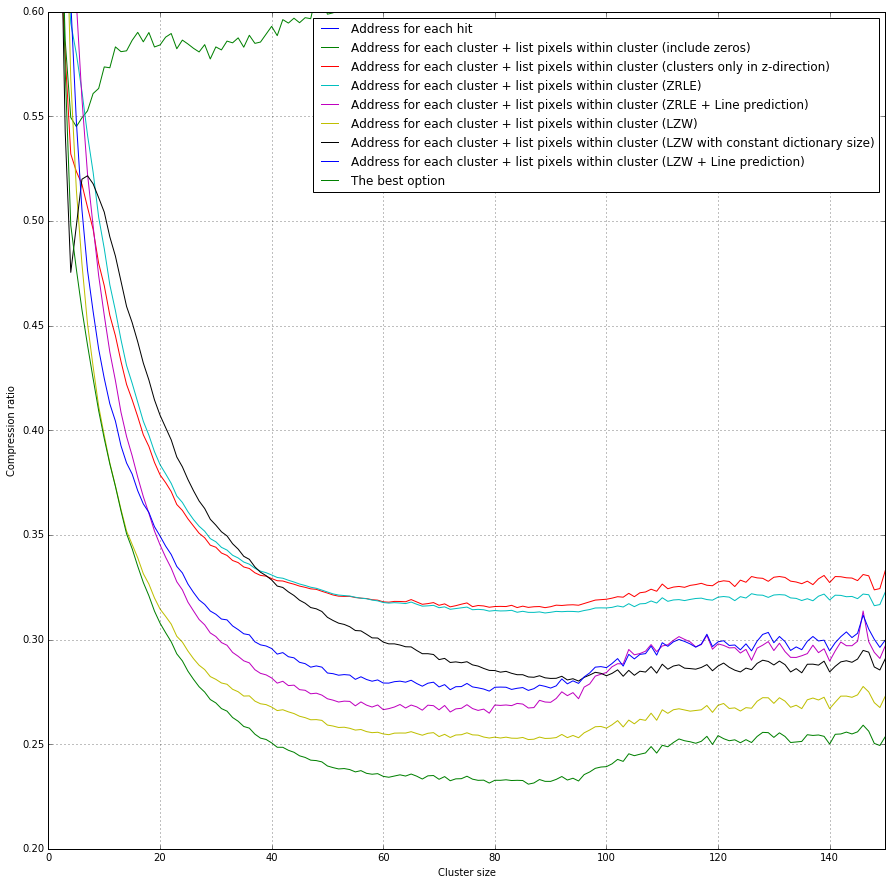

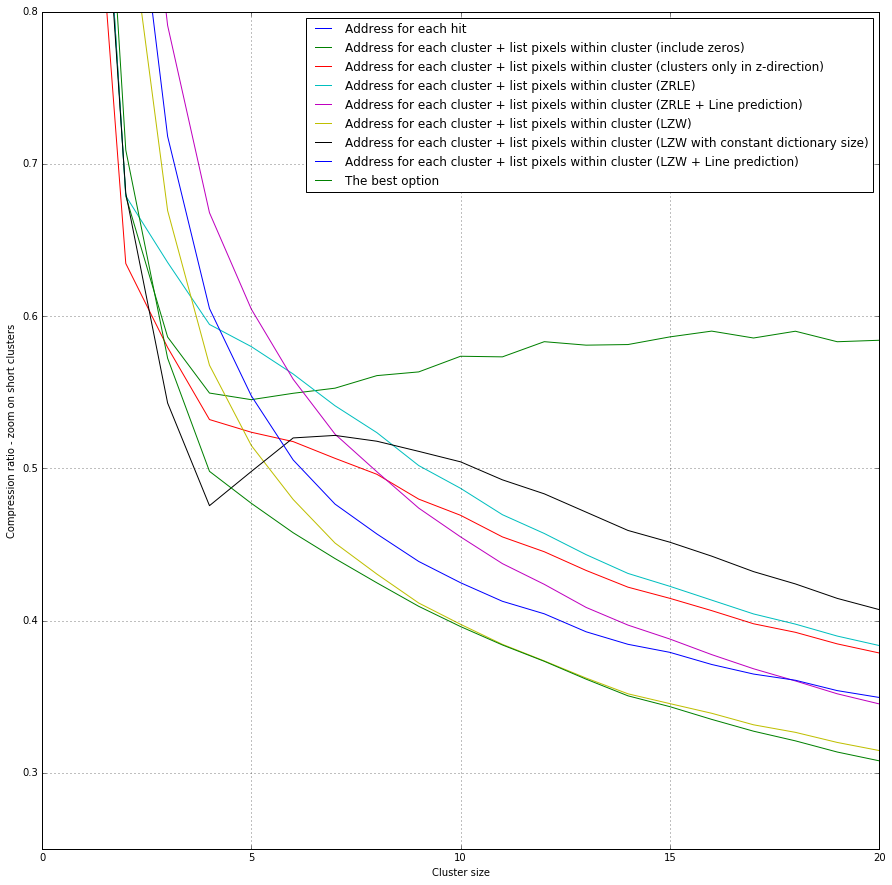

In [60]:
base_sums = np.zeros((1000))+0.00001
for i, bits in enumerate(compression_bits['base']):
    base_sums[i] = np.sum(bits)
base_total_sum = np.sum(base_sums)

compression_bits['optimal'] = [None] * 1000
for i in range(0, 1000):
    bits_for_length = np.array(compression_bits['base'][i])
    for alg in algs:
        bits_for_length = np.c_[bits_for_length, compression_bits[alg][i]]
    compression_bits['optimal'][i] = np.min(bits_for_length, axis=1) + 4

plt.figure(figsize=(15,15))
for alg in (algs + ['optimal']):
    sums = np.zeros((1000))
    for i, bits in enumerate(compression_bits[alg]):
        sums[i] = np.sum(bits)
    plt.plot( sums, label=alg_labels[alg])
    print 'Overall compression ratio(' + alg +  '):', np.sum(sums) / base_total_sum

plt.legend()
plt.xlabel('Cluster size')
plt.grid(True)
plt.ylabel('Total # bits needed')
plt.xlim([0, 20])
    
plt.figure(figsize=(15,15))
for alg in (algs + ['optimal']):
    sums = np.zeros((1000))
    for i, bits in enumerate(compression_bits[alg]):
        sums[i] = np.sum(bits)
    plt.plot(1.0*sums/base_sums, label=alg_labels[alg])
plt.legend()
plt.xlim([0, 150])
plt.ylim([0.2, 0.6])
plt.xlabel('Cluster size')
plt.grid(True)
plt.ylabel('Compression ratio')
plt.savefig('compression_optimal_all.png')

plt.figure(figsize=(15,15))
for alg in (algs + ['optimal']):
    sums = np.zeros((1000))
    for i, bits in enumerate(compression_bits[alg]):
        sums[i] = np.sum(bits)
    plt.plot(1.0*sums/base_sums, label=alg_labels[alg])
plt.legend()
plt.xlim([0, 20])
plt.ylim([0.25, 0.8])
plt.xlabel('Cluster size')
plt.grid(True)
plt.ylabel('Compression ratio - zoom on short clusters')
plt.savefig('compression_optimal_short.png')

In [29]:
compression_variation = {}
for alg in algs:
    compression_variation[alg] = []

for eta_i in range(-30, 31):
    print 'eta:', eta_i, 'phi:',
    for phi_i in range(0,16):
        print phi_i,
        for alg in algs:
            bits_per_size = get_bit_sizes_for_alg(eta_i, phi_i, alg)
            total_bits_for_module = []
            for size, bits in enumerate(bits_per_size):
                if len(bits) > 0:
                    total_bits_for_module += bits
            compression_variation[alg] += [(abs(eta_i)-1, np.sum(total_bits_for_module))]
            #print alg, np.sum(total_bits_for_module)
    print

 eta: -30 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -29 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -28 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -27 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -26 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -25 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -24 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -23 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -22 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -21 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -20 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -11 ph

3141261.81967 625094.373504
2060212.48668 602036.422955
1209676.71414 214032.90184
1240118.68648 210242.831142
1182695.84324 194642.310784
1064351.67316 176398.886209
1206040.70799 191252.146641
1162816.40574 195290.452762


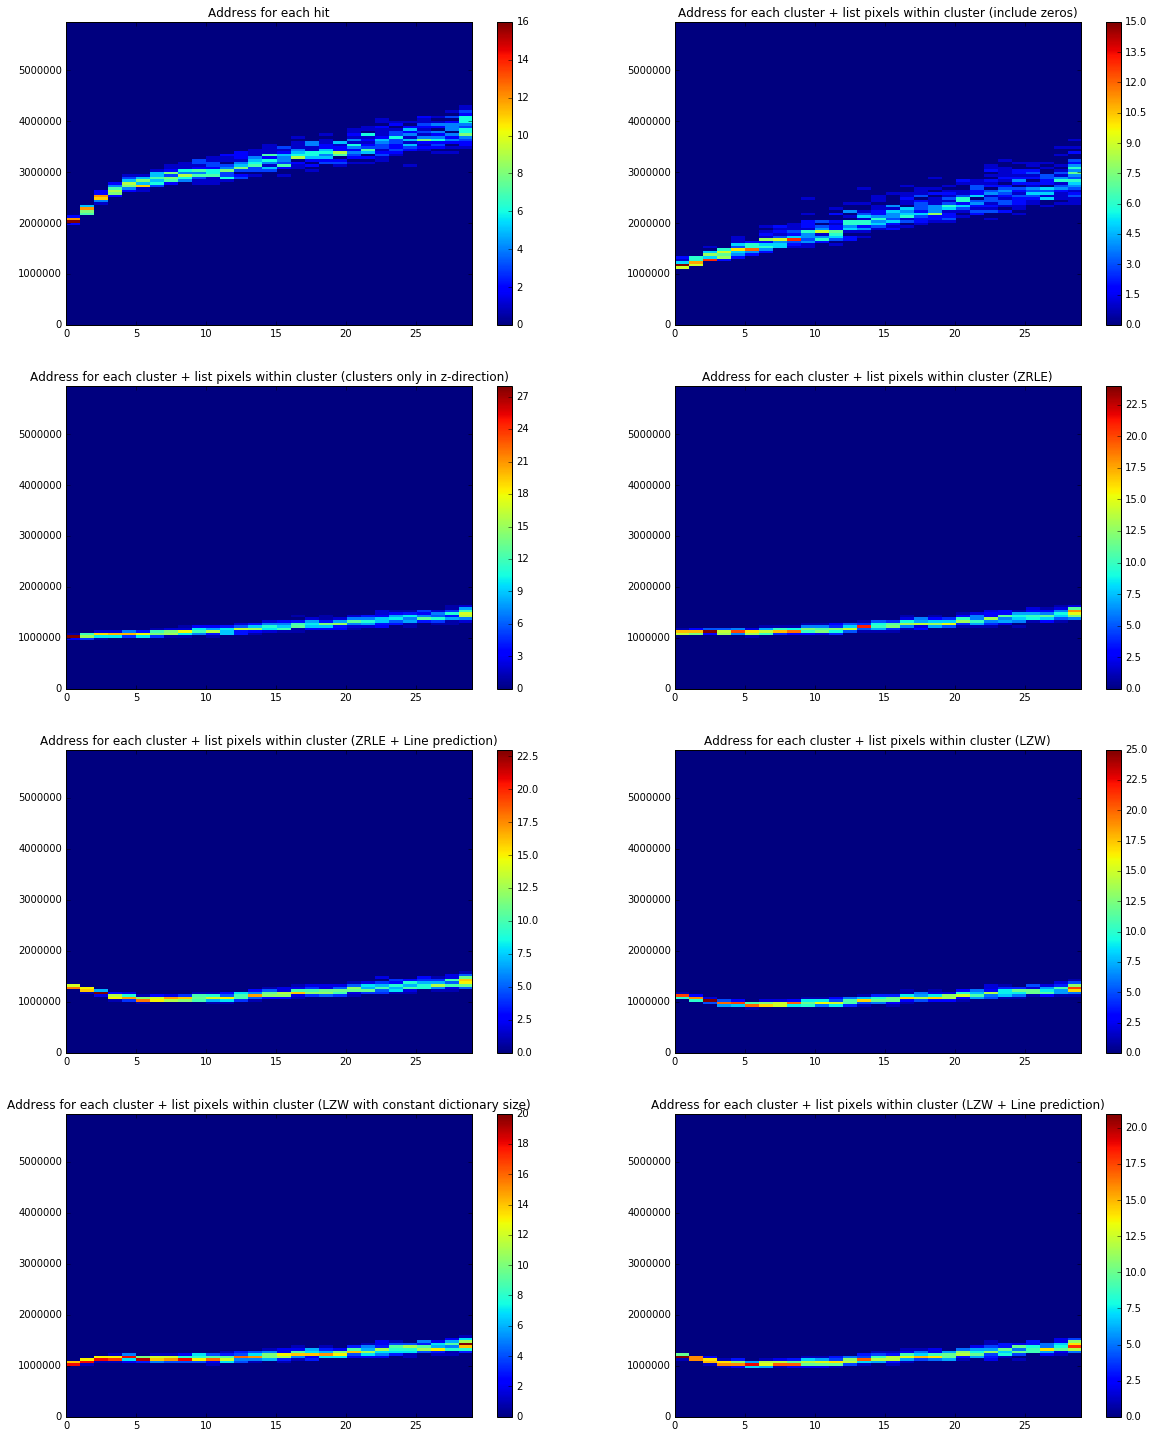

In [59]:
plt.figure(figsize=(20, 25))

for i, alg in enumerate(algs):
    plt.subplot(4, 2, i + 1)
    bits_sizes = np.array(compression_variation[alg])[:, 1]
    etas = np.array(compression_variation[alg])[:, 0]
    print np.mean(bits_sizes), np.std(bits_sizes)
    H, yedges, xedges = np.histogram2d(bits_sizes, etas, bins=(range(0, 6000000, 50000), range(0, 30)))
    plt.imshow(H, aspect=0.25, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.colorbar()
    plt.axis('tight')
    plt.title(alg_labels[alg])
plt.savefig('total_bits_per_eta.png')

In [78]:
# TODOs:
# More 'realistic scenarios'
#    1x4 regions - 32bits- compare Huffman and line prediction with bitmask - ask how the Huffman works here
#    2x8 regions - the same thing

# Look at some lossy compression methods and figure out what would be the compression ratio if lossiness was minimized

# Find shortest region chain for each event
# Find what is the ratio of clusters plit by regions
# How many clusters can you fit into 64 bit packet (128)

# Produce plot which shows data rate variation for each eta

3.16992500144
